In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import copy
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image, correct_pose, transform_original_space_to_pose
from plane_nerf.plane_nerf_optimizer import PlaneNerfCameraOptimizer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_with_box/plane-nerf/2024-02-13_150433"
DATA_PATH = "/stored_data/jackal_one_frame_box"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 * 4

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)
trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 10
trainer.pipeline.datamanager.METHOD = "sift"
trainer.pipeline.datamanager.get_inerf_batch()  

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

Loading PlaneNerfCameraOptimizer


[15:35:58] Saving checkpoints to: outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models  ]8;id=582520;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=84717;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

Number of keypoints:  62
Number of rays:  2987
Randomly select more rays
Final number of rays:  16384


In [5]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [6]:
ground_truth_poses_in_trainer = transform_original_space_to_pose(ground_truth_poses.to("cpu").float(), 
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform,
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
                                                                "opengl")
print(ground_truth_poses_in_trainer)

trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = ground_truth_poses_in_trainer.to("cpu")
pipeline.datamanager.train_dataset = pipeline.datamanager.create_train_dataset()
pipeline.datamanager.setup_train()
loss = trainer.get_loss()

corrected_pose = get_corrected_pose(trainer)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))
print(loss)
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#rendered_img = get_image(trainer.pipeline, corrected_pose[0:1,:,:])
#rendered_img = rendered_img["rgb"]

tensor([[[ 0.7735,  0.4365, -0.4595, -0.6188],
         [-0.6334,  0.5572, -0.5369, -0.6797],
         [ 0.0217,  0.7064,  0.7075,  0.0000]]])


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.5429e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(6.4541e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0197, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.0697], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 12761}


In [7]:
store = []
for theta in range(-180,180,10):
    rotation = Rotation.from_euler('z', theta, degrees=True)
    rotation = rotation.as_matrix()
    rotation = torch.tensor(rotation).unsqueeze(0).float()
    
    new_pose = rotation @ ground_truth_poses_in_trainer
    trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = new_pose.to("cpu")
    pipeline.datamanager.train_dataset = pipeline.datamanager.create_train_dataset()
    pipeline.datamanager.setup_train()
    loss = trainer.get_loss()

    corrected_pose = get_corrected_pose(trainer)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    print(loss)

    store.append([theta,float(loss["rgb_loss"]),loss["close_pixels"]])

Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.5151e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(3.1413, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0935, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1435], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 8859}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5496e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.9671, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1302, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1802], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 5253}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.3390e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.7925, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1525, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2025], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 3270}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5034e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.6180, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1557, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2057], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2549}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5487e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.4435, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1565, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2065], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2190}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7063e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.2689, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1592, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2092], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2137}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.0742e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.0944, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1610, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2110], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2155}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.3073e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.9199, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1570, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2070], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2145}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7602e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.7453, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1535, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2035], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2118}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7024e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.5708, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1463, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1963], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2256}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.4905e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.3963, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1431, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1931], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2322}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.3279e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.2217, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1373, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1873], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2199}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.4932e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.0472, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1316, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1816], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2295}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.6273e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.8727, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1258, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1758], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2417}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.6781e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.6981, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1215, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1715], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2403}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.8720e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.5236, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1086, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1586], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2851}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.6023e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.3491, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0958, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1458], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 3608}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.4210e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1745, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0674, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1174], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 6066}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.5429e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(6.4541e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0197, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.0697], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 12761}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.8875e-08, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1745, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0701, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1201], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 5825}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.3680e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.3491, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0982, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1482], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 3336}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5218e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.5236, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1092, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1592], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2537}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.6273e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.6981, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1166, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1666], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2183}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.8358e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.8727, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1262, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1762], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2106}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(3.2576e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.0472, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1342, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1842], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2199}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.3279e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.2217, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1392, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1892], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2179}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7128e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.3963, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1431, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1931], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2183}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7363e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.5708, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1463, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1963], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2270}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(1.6074e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.7453, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1512, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2012], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2265}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.3859e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.9199, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1552, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2052], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2174}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.4938e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.0944, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1555, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2055], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2270}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.5840e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.2689, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1597, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2097], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2320}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.7063e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.4435, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1610, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2110], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2423}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.9098e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.6180, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1566, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2066], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 2668}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.6023e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.7925, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1512, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.2012], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 3383}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(2.4210e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
Average rotation error:  tensor(2.9671, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1317, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1817], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 5038}


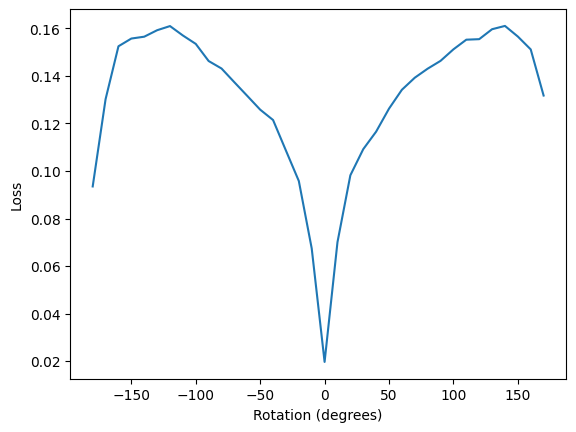

In [9]:
#Plot theta against results
store = np.array(store)
plt.plot(store[:,0],store[:,1])
plt.xlabel("Rotation (degrees)")
plt.ylabel("Loss")
plt.show()